<a href="https://colab.research.google.com/github/DarekGit/FACES_DNN/blob/master/notebooks/07_02_TrochScript_Det2MobilenetV2_model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun  8 15:36:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   6443MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import torch
import numpy as np
from PIL import Image, ImageDraw

In [ ]:
#ustaw sciezke do obrazkow
img_paths = ['IMG_5501.JPG','IMG_6331.JPG',]

In [ ]:
#zaladuj model, wejscie o stalym rozmiarze ([image BGR<3,800,1216>,],[[h,w,skala],]) (h,w) okno do odczytu,skala do odtworzenia oryginalu
!wget -q -O model.ts https://drive.google.com/uc?id=107Ym7yjAQlA6FhzAQvHoPITZnsm8Z5Co
model=torch.jit.load('model.ts')

In [ ]:
#keep aspect to match size(800,1216) of model
def to_inputs(img):
  #zmiana rozmiaru, aby najwiekszy wymiar pokrywal sie z jednym rozmiarow wejsciowych modelu (800,1216) 
  scale=1216/img.size[0]
  size=(int(img.size[1]*scale),1216)
  if size[0]>800:
    scale=800/size[0]
    size=(800,int(size[1]*scale))

  scale=size[1]/img.size[0]
  img_arg=torch.tensor([*size,scale]) #argumenty do wejscia
  img=img.resize((size[1],size[0])).crop((0,0,1216,800))
  imgs=torch.tensor(np.array(img)[:,:,::-1].copy()).permute(2,0,1).expand(1,3,800,1216).cuda() #BGR 3,800,1216
  return (imgs,img_arg.expand(1,3).cuda())

In [ ]:
if 'Script' in model.__class__.__name__: print('*')

*


In [ ]:
def draw_boxes(img,boxes,outline=(0, 255, 0),lw=1):
  imgc=img.copy()
  draw = ImageDraw.Draw(imgc)
  for box in boxes:
      draw.rectangle(box.tolist(), outline=outline, width=lw)
  imgc.show()
  return imgc

time per image :  0.059345245361328125
time per image :  0.05779910087585449
Original w h : (2048, 1536) 

Inputs arguments for fix size(w,h) 1216 x 800 h,w,scale : 
 tensor([[8.0000e+02, 1.0660e+03, 5.2051e-01]], device='cuda:0') 

outputs boxes,conf,class:
 (tensor([[651.3585,  99.4049, 694.4179, 147.0444],
        [365.4202, 149.9949, 410.4654, 200.5608]], device='cuda:0'), tensor([0.9995, 0.9986], device='cuda:0'), tensor([0., 0.], device='cuda:0')) 




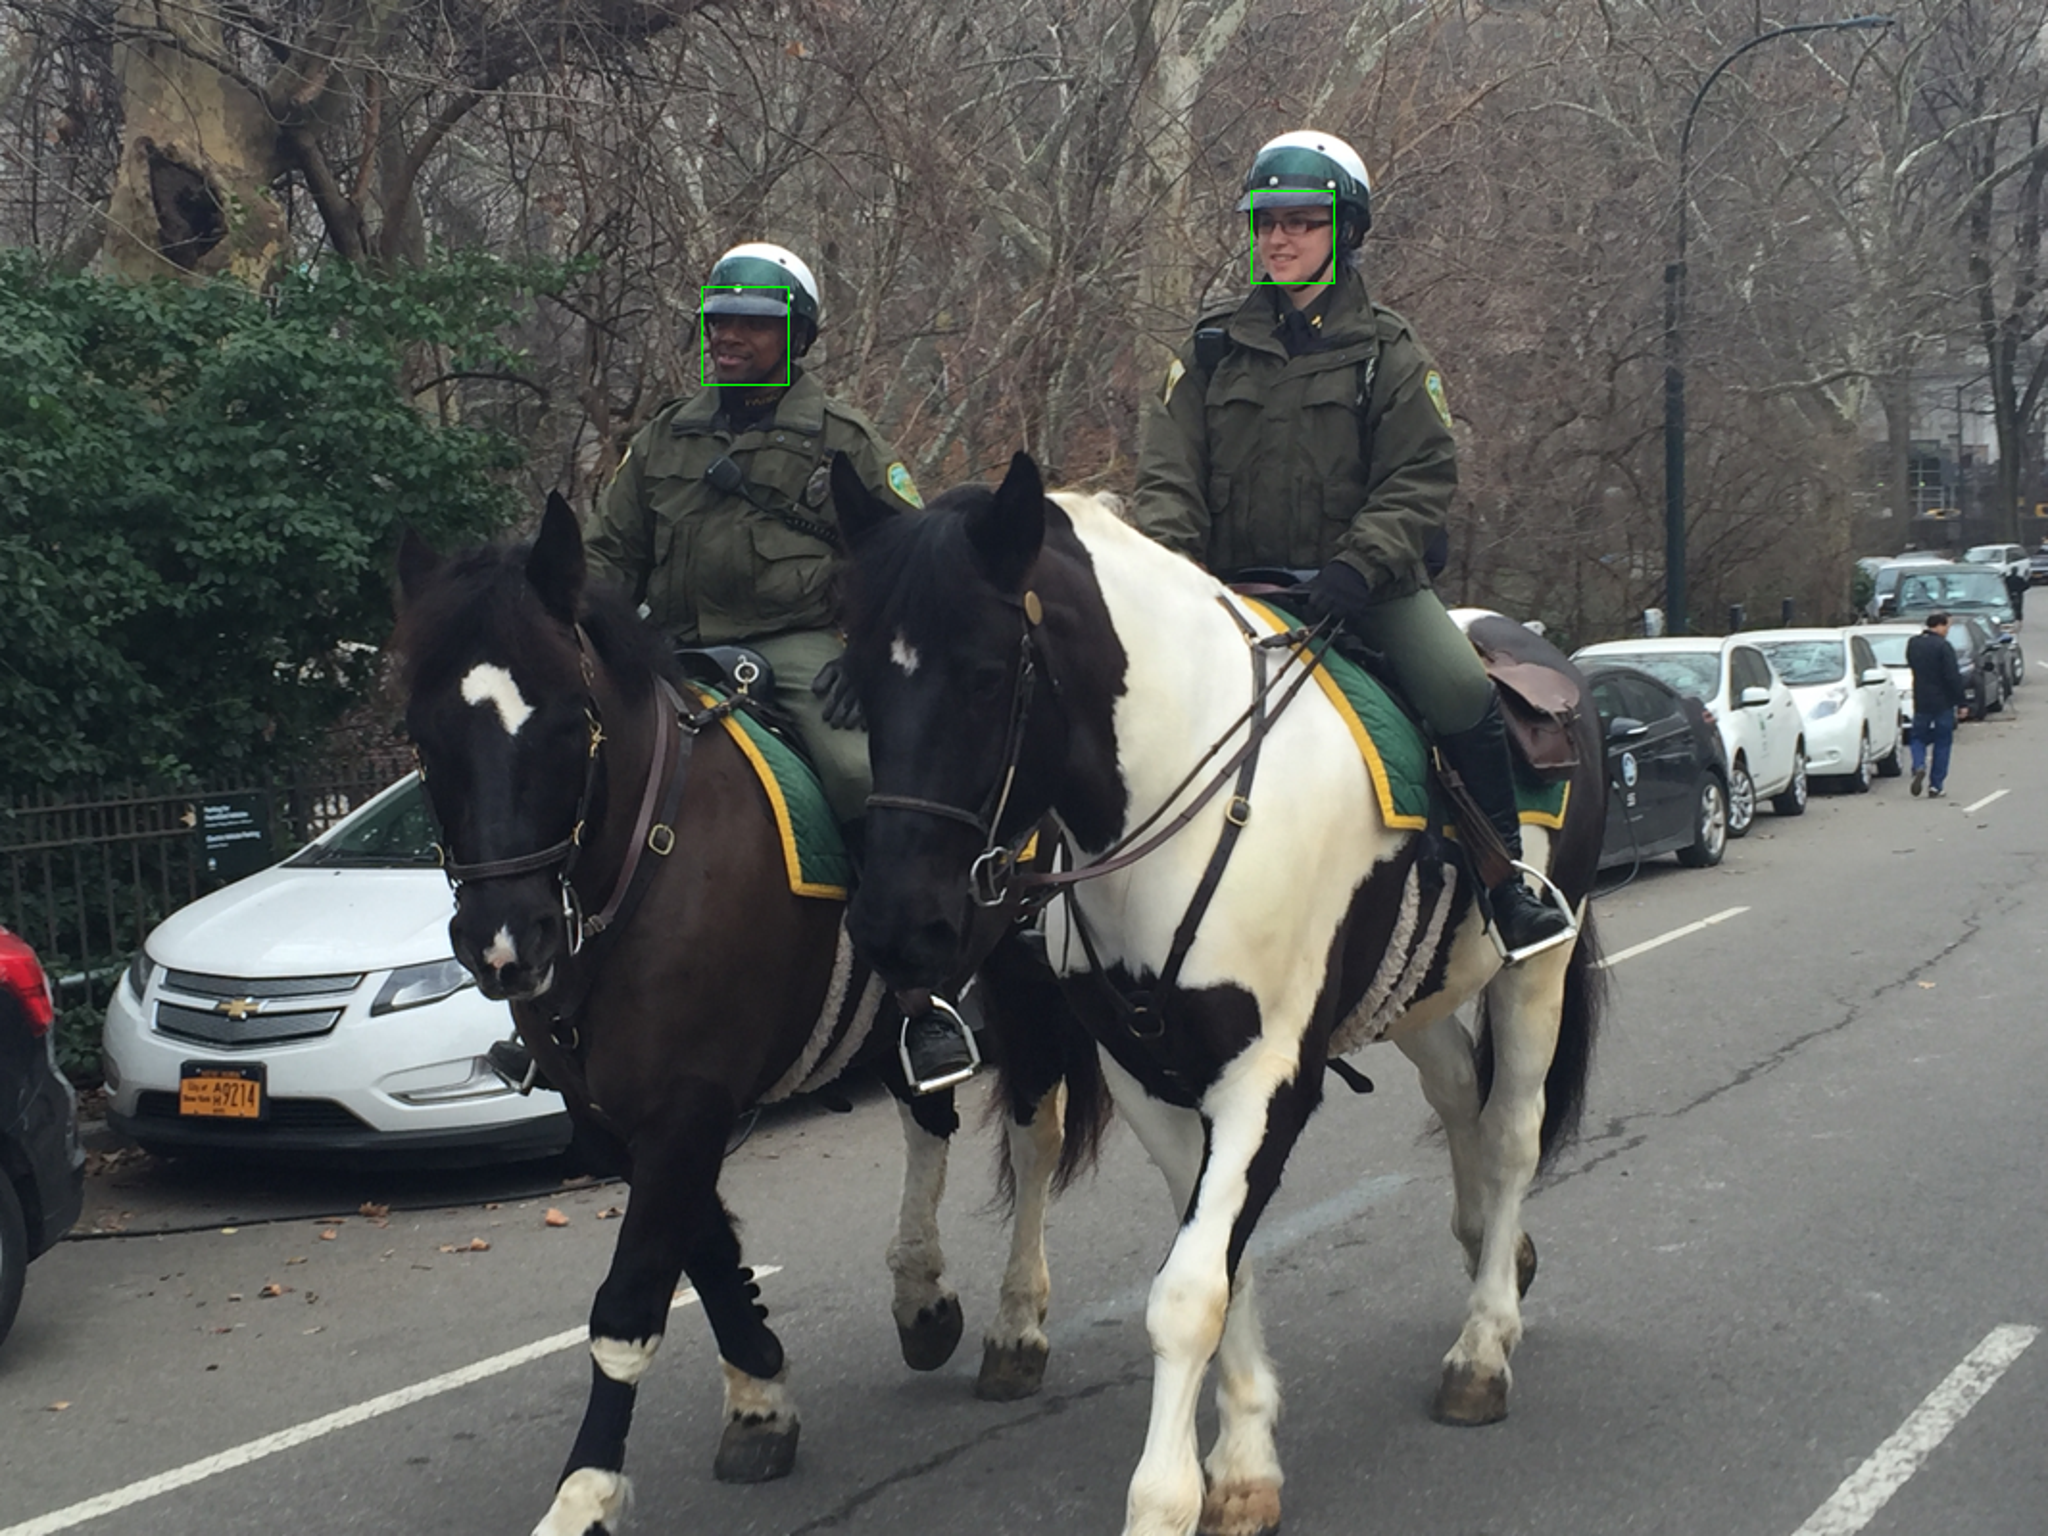

In [ ]:
import time
start=time.time()

for i,path in enumerate(img_paths):
  img=Image.open(path)
  inputs=to_inputs(img)
  
  start=time.time()
  outputs=model(inputs)
  print('time per image : ',(time.time()-start))

  h,w,s = inputs[1][0].cpu(); h,w=int(h),int(w)
  img_out=draw_boxes(img.resize((w,h)),np.array(outputs[0].cpu(),dtype=int)).crop((0,0,w,h)).resize((int(w/s),int(h/s)))
  path_o=path.split('.jpg')[0]+'_detBoxes.jpg'
  img_out.save(path_o)

print('Original w h :',img.size,'\n\nInputs arguments for fix size(w,h) 1216 x 800 h,w,scale : \n',inputs[1],'\n\noutputs boxes,conf,class:\n',outputs,'\n\n'), 
img_out

In [ ]:
imgs=torch.randn([1,3,800,1216])
imgs=imgs-torch.min(imgs)
imgs=imgs*254/torch.max(imgs)
imgs=imgs//1
inputs=(imgs.cuda(),torch.tensor([[800.,1216.,1.0]]).cuda())

In [ ]:
model(inputs)

(tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0'),
 tensor([], device='cuda:0'))